# Policy function iteration (PFI) - Coleman time iteration

In the previous notebook, I covered VFI, probably the most popular algorithm for finding the global solution to problems in macroeconomics and finance. Its popularity is due to two important factors:
1. **Robustness/stability** - VFI is is the most robust algorithm for finding global solutions. As long as Blackwell's sufficiency conditions are satisfied, then the Bellman operator is a contraction mapping, so in principle, any initial guess of the value function will eventually converge to the true and unique value function if you apply the Bellman operator enough times. Even if your model is such that Blackwell's sufficiency conditions are not met and convergence is not guaranteed, iterating on the Bellman operator is still usually the stablest procedure, since it requires the least amount of information on the problem (I will expand on this later).
2. **Simplicity** - of all the algorithms, VFI has the lowest programming overhead. I.e. the time it takes to translate your mathematical problem into the computer is the lowest. Moreover, VFI is also the only algorithm which can work with pure discretization and no interpolation whatsoever. 

Unfortunately, VFI has a major drawback: it is incredibly slow. This may seem strange since VFI solved the problem in about 0.6 seconds (actually, more accurate benchmarking shows it was about 0.424 seconds). However, it is important to compare **relative** time instead of **absolute** time when benchmarking, and I will show you algorithms that significantly faster. In this simple context, a speed improvement of an order of magnitude is still only a few miliseconds in absolute terms. Yet, as your model increases in size, this very will quickly balloon to minutes or entire hours saved - especially if you are trying to do some form of formal structural estimation.

Iterating on the Bellman operator usually means you get the approximate *shape* of the true value function fairly quickly, but getting the value function correct in the *levels* can require many (hundreds) of iterations, especially if your discount factor is close to 1. Moreover, each iteration is relatively slow - since optimizing a function is usually a very computationally costly step and can require many function evaluations within each step.

Fortunately, there are two other ways of solving recursive problems and they are both significantly faster than VFI. They are Coleman time-iteration, and the endogenous grid method, and they both involve iterating the **policy function** on the Euler equation instead of the value function on the Bellman equation.

# 0. Introduction
At the end of the notebook on VFI, I showed how the Euler equation can be used to assess a numerical policy function's accuracy. Fortunately, it turns out that the Euler equation can also be used to **find** the policy function itself! The main conceptual difference between PFI and VFI is that while the latter involves iterating guesses of the value function on the Bellman equation, PFI requires iterating guesses of the policy function on the Euler equation.

The iterative procedure is the following:
1. Guess a policy function for next period's capital: $k^\prime = g_0(k)$
2. On your grid of $k$'s, construct the Euler equation:
$$
u_c(f(k_i) - k^\prime_i) = \beta f_k(k^\prime_i)u_c(f(k^\prime_i) - g_0(k^\prime_i))
$$
3. For each $k_i$, use a non-linear root-finder to find the $k^\prime_i$ that satisfies the Euler equation
4. There's now a new mapping between $k$ and $k^\prime$! Interpolate to create $g_1(k)$.
5. Compute the distance between $g_1(k)$ and $g_0(k)$. If the norm is less than your tolerance, stop. If not, update your guess of the policy function with $g_1(k)$ and repeat from Step 2 until convergence.

# 1. Initialization
Fortunately, the initialization step is almost identical to that of VFI. The only differences are that firstly, instead of optimization, a package for numerical root-finding is used, and secondly, we need to define two additional functions to facilitate constructing the Euler equation.

In [1]:
using Interpolations, LinearAlgebra, Roots, Plots

const β = 0.96
const α = 0.4

const kmin = 1e-3;
const kmax = 100.0;
const nk = 1_001;
const kgrid = range(kmin, kmax, length=nk)

f(k) = k^α
u(c) = c ≥ 0.0 ? log(c) : -1e10
u_c(c) = c ≥ 0.0 ? 1/c : 0.0
f_k(k) = α * k^(α - 1)

f_k (generic function with 1 method)

# 2. Coleman operator



In [2]:
function coleman_operator(polguess_V::Vector{Float64})
    polguess_F = CubicSplineInterpolation(kgrid, polguess_V)
    Kp_V = zeros(nk)
    for i in eachindex(kgrid)
        k = kgrid[i]
        function euler_eq(k′)
            LHS = u_c(f(k) - k′)
            c′ = f(k′) - polguess_F(k′)
            RHS = β*f_k(k′)*u_c(c′)
            return LHS - RHS
        end
        Kp_V[i] = find_zero(euler_eq, (kmin, f(k)))
    end
    return Kp_V
end

coleman_operator (generic function with 1 method)

In [4]:
function solve_model_coleman()
    polguess_V = zeros(nk)
    iiter = 0
    diff = 1
    max_iter = 600
    tol = 1e-8

    @time while iiter < max_iter 
        iiter += 1
        polnew_V = coleman_operator(polguess_V)

        diff = norm(polnew_V - polguess_V, Inf)

        println("Iteration $iiter, Error: $diff")

        polguess_V = copy(polnew_V)

        if diff < tol
            println("Converged after $iiter iterations")
            break
        end
    end
    return polguess_V
end

pol_V = solve_model_coleman();

Iteration 1, Error: 1.7506330945115192
Iteration 2, Error: 0.4389568555464729
Iteration 3, Error: 0.14688290683572713
Iteration 4, Error: 0.053431714606226866
Iteration 5, Error: 0.020280034479680964
Iteration 6, Error: 0.007679063548811538
Iteration 7, Error: 0.002884560209381881
Iteration 8, Error: 0.0010764313351376842
Iteration 9, Error: 0.000400140596824361
Iteration 10, Error: 0.00014844659028367957
Iteration 11, Error: 5.5016115252826125e-5
Iteration 12, Error: 2.0379317269281216e-5
Iteration 13, Error: 7.547082452319387e-6
Iteration 14, Error: 2.794560049146355e-6
Iteration 15, Error: 1.0347139665078942e-6
Iteration 16, Error: 3.831011885502278e-7
Iteration 17, Error: 1.4184038255038445e-7
Iteration 18, Error: 5.251494483715646e-8
Iteration 19, Error: 1.9443044507738705e-8
Iteration 20, Error: 7.198546203568412e-9
Converged after 20 iterations
  0.076540 seconds (2.44 k allocations: 2.596 MiB)


Incredibly, Coleman time-iteration managed to find the policy function in just 20 iterations as opposed to 455, resulting in the time-to-compute dropping from about 424 miliseconds to just 76!

Let's evaluate the numerical accuracy of PFI by calculating the Euler residuals again.

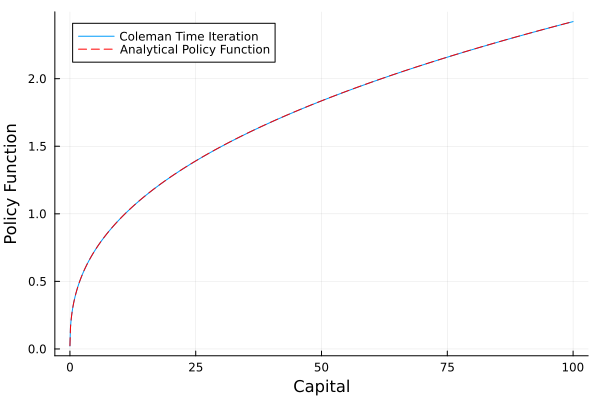

In [ ]:
plot(kgrid, pol_V, label="Coleman time iteration", 
    xlabel="Capital", ylabel="g(k)")

pol_analytical(k) = α*β*k^α

plot!(kgrid, pol_analytical.(kgrid), label="Analytical policy function", 
    linestyle=:dash, color=:red)

In [6]:
pol_F = CubicSplineInterpolation(kgrid, pol_V)

function compute_euler_residual(k::Float64)
    k′ = pol_F(k)
    c = f(k) - k′
    LHS = u_c(c)
    k′′ = pol_F(k′)
    c′ = f(k′) - k′′
    RHS = β * f_k(k′) * u_c(c′)
    return log10(abs(LHS/RHS - 1))
end

kfine_V = range(kmin, kmax, length=5_001)
errors_V = compute_euler_residual.(kfine_V)

using Statistics

mean(errors_V)

-8.702761140744553

Thus, we can see that PFI is not only significantly faster than VFI, it results in much more accurate policy functions too!